In [1]:
# add path (for local)
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [ ]:
%load_ext autoreload
%autoreload 2
from datetime import datetime
import importlib
import numpy as np
import logging
import os
import random
import shutil
import time
import torch
from typing import Any
import yaml
from rdkit import RDLogger
from generator import Generator
from language import Language, MolLanguage
from node import SurrogateNode, SentenceNode, MolSentenceNode
from utils import add_sep, class_from_package, make_logger

RDLogger.DisableLog('rdApp.*') # use debug: true to log invalid mols

def read_yaml(yaml_path: str) -> tuple[Generator, dict[str, Any]]:
    with open(os.path.join(repo_root, yaml_path)) as f:
        conf = yaml.safe_load(f)

    output_dir=os.path.join(repo_root, "sandbox", conf["output_dir"], datetime.now().strftime("%m-%d_%H-%M")) + os.sep
    file_level = logging.DEBUG if conf.get("debug") else logging.INFO
    logger = make_logger(output_dir, file_level=file_level)

    if "seed" in conf:
        seed = conf["seed"]
    else:
        seed = int(time.time()) % (2**32)
    logger.info("seed: " + str(seed))
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    generator_args = conf.get("generator_args", {})

    transition_args = conf.get("transition_args", {})
    if "model_dir" in transition_args:
        transition_args["model_dir"] = os.path.join(repo_root, transition_args["model_dir"])
    lang_path = conf.get("lang_path")
    if lang_path is None:
        lang_name = os.path.basename(os.path.normpath(transition_args["model_dir"])) + ".lang"
        lang_path = add_sep(transition_args["model_dir"]) + lang_name
    lang = Language.load(lang_path)
    transition_class = class_from_package("transition", conf["transition_class"])
    transition = transition_class(lang=lang, logger=logger, device=conf.get("device"), **transition_args)

    reward_class = class_from_package("reward", conf.get("reward_class"))
    reward = reward_class(**conf.get("reward_args", {}))
    
    if "policy_class" in conf:
        policy_class = class_from_package("policy", conf.get("policy_class"))
        policy = policy_class(**conf.get("policy_args", {}))
        generator_args["policy"] = policy

    filter_settings = conf.get("filters", [])
    filters = []
    for s in filter_settings:
        filter_class = class_from_package("filter", s.pop("filter_class"))
        filters.append(filter_class(**s))

    if "node_class" in conf:
        node_class = class_from_package("node", conf.get("node_class"))
    elif issubclass(lang.__class__, MolLanguage):
        node_class = MolSentenceNode
    elif issubclass(lang.__class__, Language):
        node_class = SentenceNode
    if node_class == MolSentenceNode:
        MolSentenceNode.use_canonical_smiles_as_key = conf.get("use_canonical_smiles_as_key", True)
   
    if type(conf.get("root")) == list:
        root = SurrogateNode()
        for s in conf.get("root"):
            node = node_class.node_from_key(string=s, lang=lang, device=conf.get("device"))
            root.add_child(action=s, child=node)
    else:
        root = node_class.node_from_key(string=conf.get("root", ""), lang=lang, device=conf.get("device"))
    
    generator_class = class_from_package("generator", conf.get("generator_class", "MCTS"))
    generator = generator_class(root=root, transition=transition, reward=reward, filters=filters, output_dir=output_dir, logger=logger, **generator_args)

    src = os.path.join(repo_root, yaml_path)
    dst = os.path.join(output_dir, "setting.yaml")
    shutil.copy(src, dst)
    return generator, conf

def generate_and_analyze(generator, conf):
    generator.generate(time_limit=conf.get("time_limit"), max_generations=conf.get("max_generations"))
    generator.plot(**conf.get("plot_args", {}))
    generator.analyze()

def queue_generations(*args: str):
    for yaml_path in args:
        generator, conf = read_yaml(yaml_path)
        generate_and_analyze(generator, conf)

seed: 1751264235
Starting generation...
<best reward updated> order: 1, time: 0.00, reward: 0.7172, node: C/C(=C(/C#N)C(=O)Nc1cc(Cl)ccc1OC(F)F)c1ccccc1F
<best reward updated> order: 3, time: 0.25, reward: 0.7215, node: NC(=O)c1ccc(/C=C/C(=O)OC(c2ccccc2)c2ccccc2)cc1
<best reward updated> order: 5, time: 0.27, reward: 0.7697, node: N#Cc1ccc(C(=O)Nc2ccccc2C(=O)Nc2ccc(Br)cc2)cc1
<best reward updated> order: 17, time: 0.39, reward: 0.7702, node: O=C(Nc1ccccc1[C@H](O)c1cccc(Br)c1)c1ccc2ccccc2c1
generated: 100, time: 1.29, average over 100: 0.0458
<best reward updated> order: 153, time: 1.86, reward: 0.8122, node: C/C(=N\NC(=O)Cc1cccs1)C(C)C
generated: 200, time: 2.37, average over 100: 0.2248
<best reward updated> order: 262, time: 3.02, reward: 0.8453, node: Cc1nc(CC(=O)NCC2(c3ccc(-c4cccs4)s3)CC2)cs1
generated: 300, time: 3.42, average over 100: 0.1716
generated: 400, time: 4.54, average over 100: 0.3229
generated: 500, time: 5.59, average over 100: 0.2999
<best reward updated> order: 503, 

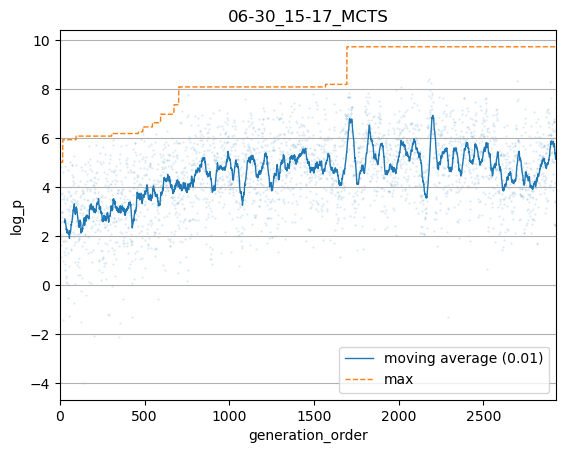

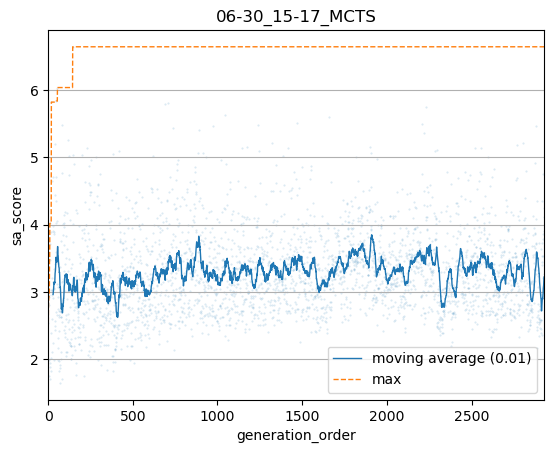

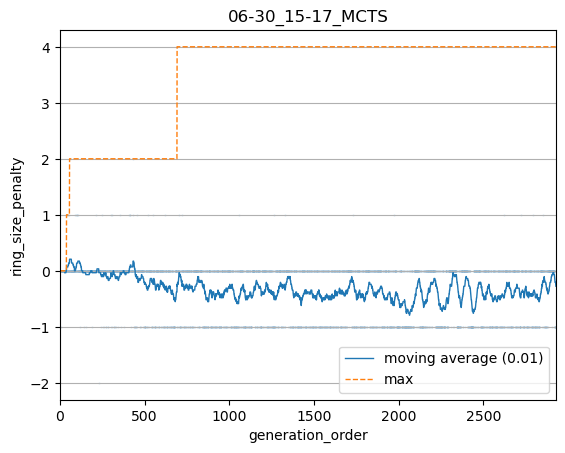

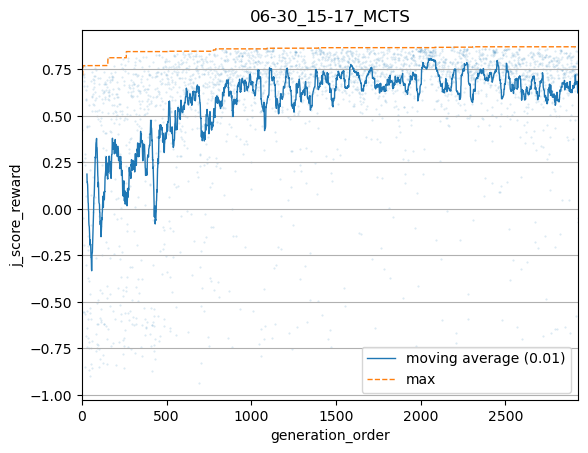

number of generated nodes: 2929
valid rate: 0.9546578730420445
unique rate: 0.8502335806540258
node_per_sec: 96.56703714912472
best_reward: 0.871134473185901
average_reward: 0.574774115704972


In [3]:
# start generation
c1 = "config/mcts_d_score_replication.yaml"
c2 = "config/mcts_helm.yaml"
c3 = "config/mcts_smiles.yaml"
c4 = "config/model_test.yaml"
c5 = "config/mcts_d_score.yaml"
c6 = "config/mcts_j_score.yaml"
generator, conf = read_yaml(c3)
generate_and_analyze(generator, conf)
# queue_generations(c1, c2)

In [ ]:
#continue search
generator.generate(time_limit=conf.get("time_limit") - generator.passed_time, max_generations=conf.get("max_generations") - len(generator.unique_keys))
generator.plot(**conf.get("plot_args", {}))
generator.analyze()

In [16]:
#save mcts
save_path = generator.output_dir() + "save.mcts"
generator.save(save_path)

In [ ]:
#load generator and yaml
load_dir = "generation_result/06-26_08-51/"
generator, conf = read_yaml("sandbox/" + load_dir + "setting.yaml")
generator = Generator.load(load_dir + "save.mcts", generator.transition)

In [ ]:
#time test
import cProfile
import pstats

profiler = cProfile.Profile()
profiler.enable()
read_yaml(c2)
profiler.disable()

stats = pstats.Stats(profiler)
stats.sort_stats("cumtime").print_stats(100)